$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Part 5b: Control a Marble with Reinforcement Learning

Fawad Ahmad

## Overview

In this there is second marble which is moving independently and they have to learn not to bump into eachother. There is no goal this time so the marbles are free to do what so ever they want. This program is only for the one dimension. Following are the generalizations i have made.
* When marbles come in certain range of each other(which is considered collision), they get negative reinforcement so that they learn that they don't have to do that action again.

## Functions

* $initialState$ takes the velocity and position of marbles randomly for the first time.
* $nextState$ It updates position and velocity of the marble. 
* $reinforcement$ is to look for the positions of two marbles and if they are going to hit each other then give it negative reinforcement.
* $policy$ is to get new action randomly or by looking into the qnet for a good action.
* $makeSamples$ is to get all the samples considering one starting point so that when we give it to the system, it learns better.
* $plotStatus$ is to show the position and velocity of marbles.

In [1]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy

%matplotlib inline

In [2]:
validActions = np.array([ -1, 0, 1])

def initialState():
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample())])

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0])
    elif s[0] > 10:
        s = np.array([10,0])
    return s

def reinforcement(s1,s2):  # s is new state
    goal = 2
    R = np.zeros(2)
    if s1[0] > s2[0]-0.1 or s1[0] < s2[0]+0.1:
        R[0] = -1
        R[1] = -1
    if abs(s1[0]-goal)<1:
        R[0] = 0
    else:
        R[0] = -0.1
    if abs(s2[0]-goal)<1:
        R[1] = 0  
    else:
        R[1] = -0.1    
    return R

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

Now we need a function to generate a bunch of samples that are interactions with the marble.

In [3]:
def makeSamples(qnet1,qnet2, nStepsPerStart):
    samples = []
    
    state1 = initialState()
    state2 = initialState()
    act1 = policy(qnet1, state1, epsilon)
    act2 = policy(qnet2, state2, epsilon)
    oldact1 = act1
    oldact2 = act2
    for iStep in range(nStepsPerStart):
        newState1 = nextState(state1, act1)
        newState2 = nextState(state2, act2)
        r = reinforcement(newState1,newState2)
        newAct1 = policy(qnet1, newState1, epsilon)
        newAct2 = policy(qnet2, newState2, epsilon)
        # SARSA
        samples.append(state1.tolist() + [act1, r[0]] + newState1.tolist() + [newAct1]+ state2.tolist() + [act2, r[1]] + newState2.tolist() + [newAct2])
        state1 = newState1
        state2 = newState2
        oldact1 = act1
        oldact2 = act2
        act1 = newAct1
        act2 = newAct2
    return np.array(samples)

Now we can play.  Define constants we need.

In [4]:
def plotStatus(qnet1, X1, R1, trial,epsilonTrace,rtrace1,qnet2, X2, R2,rtrace2,qnet3,qnet4,X3,X4):
 
    plt.subplot(2,1,2)
    plt.plot(X1[:,0],X3[:,0])
    plt.plot(X1[0,0],X3[0,0],'o')
    plt.plot(X2[:,0],X4[:,0])
    plt.plot(X2[0,0],X4[0,0],'o')
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    
    s = plt.subplot(2,1,1)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)    
    ax.plot(X1[:,0], X3[:,0], (2 ** X1[:,1]) + (2 ** X3[:,1])**(1/2.0), zdir='z', label='ys=0, zdir=z')
    ax.scatter(X1[0,0], X3[0,0], (2 ** X1[0,1]) + (2 ** X3[0,1])**(1/2.0))
    ax.plot(X2[:,0], X4[:,0], (2 ** X2[:,1]) + (2 ** X4[:,1])**(1/2.0), zdir='z', label='ys=0, zdir=z')
    ax.scatter(X2[0,0], X4[0,0], (2 ** X2[0,1]) + (2 ** X4[0,1])**(1/2.0))
    #plt.plot(X[0,0],X[0,1],'o')
    #ax.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("Velocity")
    plt.title(" Average Velocity vs position")  
      



In [5]:
gamma = 0.999
nTrials = 500
nStepsPerTrial = 1000 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

In [6]:
epsilonDecay

0.9908319448927676

In [9]:
nh = [5,5]
qnet1 = nn.NeuralNetwork([3] + nh + [1])  # [3, 5, 5, 1]
qnet2 = nn.NeuralNetwork([3] + nh + [1])  # [3, 5, 5, 1]

qnet3 = nn.NeuralNetwork([3] + nh + [1])  # [3, 5, 5, 1]
qnet4 = nn.NeuralNetwork([3] + nh + [1])  # [3, 5, 5, 1]

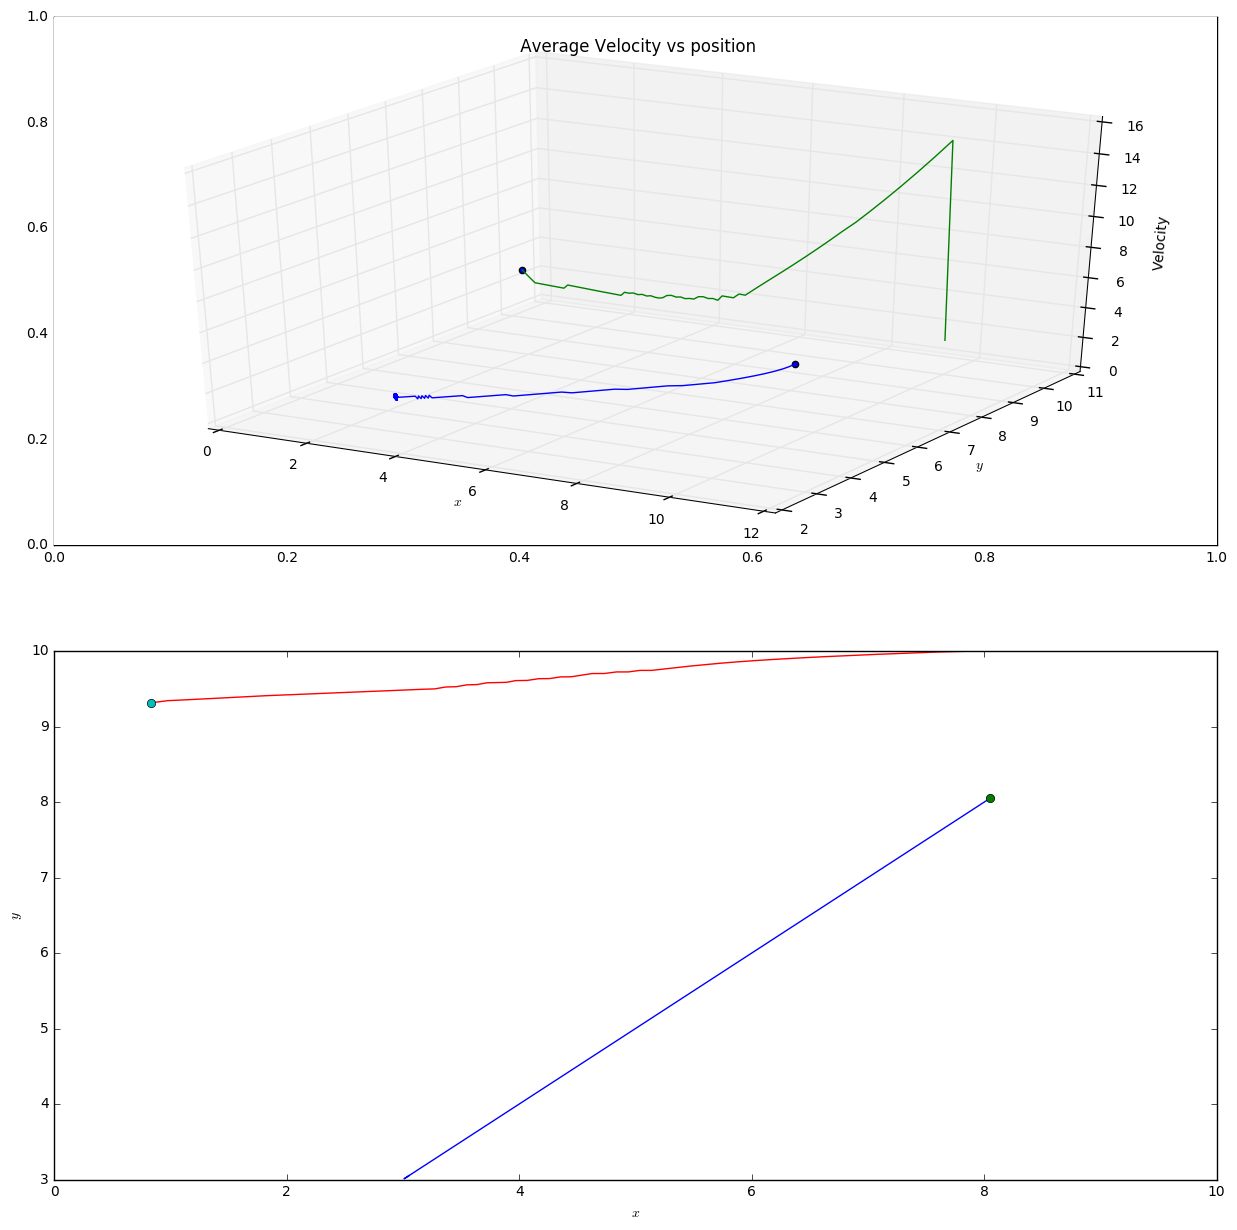

In [11]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace1 = np.zeros(nTrials)
rtrace2 = np.zeros(nTrials)

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    # for X
    samples = makeSamples(qnet1,qnet2, nStepsPerTrial)
    samples1 = samples[:, :7]
    samples2 = samples[:, 7:14]
    ns = 2
    na = 1
    X1 = samples1[:, :ns+na]
    R1 = samples1[:, ns+na:ns+na+1]
    nextX1 = samples1[:, ns+na+1:]
    nextQ1 = qnet1.use(nextX1)

    qnet1.train(X1, R1 + gamma * nextQ1, nIterations = nSCGIterations)
 
    X2 = samples2[:, :ns+na]
    R2 = samples2[:, ns+na:ns+na+1]
    nextX2 = samples2[:, ns+na+1:]
    nextQ2 = qnet2.use(nextX2)

    qnet2.train(X2, R2 + gamma * nextQ2, nIterations = nSCGIterations)
    
    # for Y
    
    samples = makeSamples(qnet3,qnet4, nStepsPerTrial)
    samples3 = samples[:, :7]
    samples4 = samples[:, 7:14]
    ns = 2
    na = 1
    X3 = samples1[:, :ns+na]
    R3 = samples1[:, ns+na:ns+na+1]
    nextX3 = samples1[:, ns+na+1:]
    nextQ3 = qnet3.use(nextX3)

    qnet3.train(X3, R3 + gamma * nextQ3, nIterations = nSCGIterations)
 
    X4 = samples4[:, :ns+na]
    R4 = samples4[:, ns+na:ns+na+1]
    nextX4 = samples4[:, ns+na+1:]
    nextQ4 = qnet4.use(nextX4)

    qnet4.train(X4, R4 + gamma * nextQ4, nIterations = nSCGIterations)
    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace1[trial] = np.mean(R1)
    rtrace2[trial] = np.mean(R2)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet1, X1, R1, trial,epsilonTrace,rtrace1,qnet2, X2, R2,rtrace2,qnet3,qnet4,X3,X4)
        #testIt(qnet,10,500)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

## Analysis 
Following are the observations
* During first few trainings, marbles collide and then they learn not to. So last graph shows that if one is on the same goal then other can't go there.
* Graph shows that marbles have learned how not to collide. So they change their velocities to avoid collision.
* Both marbles have different qnet but they learn well from their mistakes. 
* if both have to go to the same location, the other can't approach that as they have learned not to collide as shown in the picture.
* even if the marbles collide in the final output of second graph, we can't say that system haven't learned as there is also velocity graph to give insight.